This notebook will be used to look at and understand the model output currents through Juan de Fuca with the use of ellipses

In [64]:
import os
import datetime
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import subprocess as sp
from subprocess import Popen, PIPE

import netCDF4 as nc
from salishsea_tools import viz_tools

%matplotlib inline

#Which grid poitns are we interested in?

In [65]:
thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
grid = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
fB = nc.Dataset(grid)
bathy = fB.variables['Bathymetry'][:]
lons = fB.variables['nav_lon'][:]
lats = fB.variables['nav_lat'][:]

###Forman locations

In [66]:
#Juan de Fuca West
iJW=8
jJW=408

#Juan de Fuca East
iJE = 151
jJE = 275

[0, 220, 200, 450]

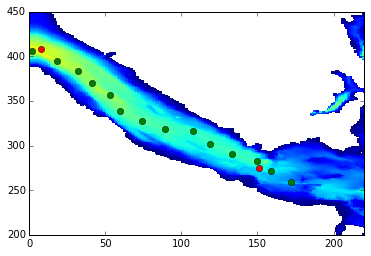

In [67]:
plt.pcolormesh(bathy)
plt.plot(iJW,jJW,'ro')
plt.plot(iJE,jJE,'ro')
plt.plot(thalweg[1,0:350:25],thalweg[0,0:350:25], 'go')
plt.axis([0,220,200,450])

##Load parameters

In [68]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 7, 13)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

loc = np.arange(0,350,25)
count = np.arange(0,len(loc))
parj = np.zeros((len(loc),39,5))
parj_av = np.zeros((len(loc),8))
cols=np.arange(0,5)

i = np.zeros((14))
j = np.zeros((14))


for k,l in zip(loc,count):
    i = thalweg[1,loc]
    j = thalweg[0,loc]
    runname1 = '{}_{}_JdF_{}'.format(t_o, t_f, k)
    runname2 = '{}_{}_JdF_{}_depav(0-400)'.format(t_o, t_f, k)
    df1 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/JuandeFuca/'+runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/JuandeFuca/'+runname2+'.csv', index_col=False)
    parj[l,:,:] = df1.as_matrix()
    parj_av[l,:] = df2.as_matrix()


##Plot model ellipses

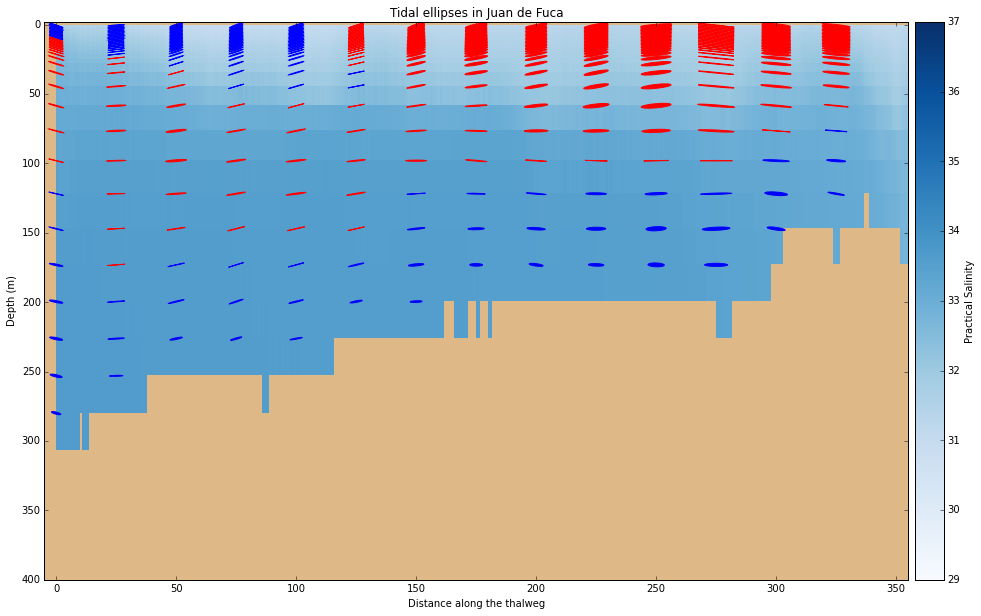

In [69]:
# Set up the figure and axes
fig, (axl, axcb) = plt.subplots(1, 2, figsize=(20, 10))
land_colour = 'burlywood'
axl.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))

smin, smax, dels = 29, 37, 0.5
cmap = plt.get_cmap('Blues')
cmap.set_bad(land_colour)
tracers = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/18sep27sep/SalishSea_1d_20030918_20030927_grid_T.nc')
sal = tracers.variables['vosaline']
npsal = sal[:]
zlevels = tracers.variables['deptht']
sal_0 = npsal[-1, :, thalweg[0], thalweg[1]]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)
mesh = axl.pcolormesh(x, z, sal_tzyx.T, cmap=cmap, vmin=smin, vmax=smax)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity')

scale = 15
for c, ind in zip(count, loc):
    for dep, value in zip(np.arange(0,39), parj[0,:,0]):
        if parj[c,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(xy=(ind, value), width=scale*parj[c,dep,1], 
                            height=scale*parj[c,dep,2], angle=parj[c, dep,3],
                            color=thec)
        axl.add_artist(ellsc)
        ellsc.set_facecolor(thec)

axl.set_ylim(-2,400)
axl.invert_yaxis()
axl.set_xlim(-5,355)
axl.set_title('Tidal ellipses in Juan de Fuca')
axl.set_ylabel('Depth (m)')
axl.set_xlabel('Distance along the thalweg')

##Get Foreman values

In [70]:
i = thalweg[1,loc]
j = thalweg[0,loc]

lon = lons[j,i]
lat = lats[j,i]

In [71]:
parjf = np.zeros((14,8))
os.chdir(r'/ocean/mdunn/Tides/')
for k in count:
    p = Popen(["matlab","-nodesktop","-nodisplay","-r", "findparam(%s,%s)" % (lon[k], lat[k])], stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    parjf[k] = np.loadtxt('output.txt')

#Compare models
##Maps

In [78]:
csv1 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/param_mat.csv', index_col=False)
param_mat = csv1.as_matrix()
csv2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/params.csv', index_col=False)
params = csv2.as_matrix()

red is clockwise


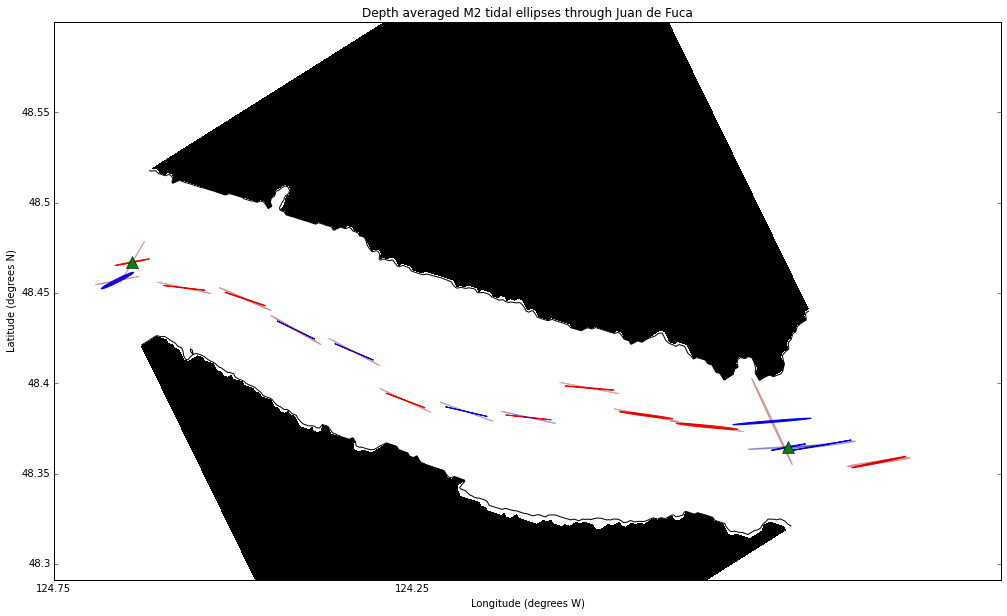

In [73]:
phi=29
fig = plt.figure(figsize=(20,10))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 2
scale = 25
imin = min(i)
imax = max(i)

jmin = min(j)
jmax = 425

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 

for index, x, y in zip(count, i ,j):
    if parj_av[index,1] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*parj_av[index,0], 
                        height=scale*parj_av[index,1], angle=parj_av[index,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)
    
    if parjf[index,1] > 0:
        thec = [0,0,0.6, 0.3]
    else:
        thec = [0.6,0,0, 0.3]
    ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*parjf[index,0],
                        height=scale*parjf[index,1], angle=parjf[index,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)
    
#Plot the Haro Strait current meter location    
ax.plot(m[jJE,iJE], k[jJE,iJE],'g^', markersize=12) 
ax.plot(m[jJW,iJW], k[jJW,iJW],'g^', markersize=12)  

#Values from EllipsesComparisonswithForemanModel notebook [Salishparam,Foremanparam]

for ind, x, y in zip([0,1], [iJW,iJE], [jJW,jJE]):
    if params[ind,1] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*params[0,0], 
                        height=scale*params[0,1], angle=params[0,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

    if param_mat[ind,1] > 0:
        thec = [0,0,0.6, 0.3]
    else:
        thec = [0.6,0,0, 0.3]
    ellsc = Ellipse(xy=(m[y,x],k[y,x]), width=scale*param_mat[ind,0],
                        height=scale*param_mat[ind,1], angle=param_mat[ind,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude
ax.set_ylim(280,395)
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(47.13, 47.8, 0.1)-
                           lats[jmin,imin])/slope).tolist()
labels = ['48.3','48.35', '48.4', '48.45', '48.5', '48.55']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
#x-axis in m, but labelled in longitude
ax.set_xlim(0,60)
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-125.01,-124.5,0.5)-
                        lons[jmin,imin])/slope).tolist()
labels = ['124.75','124.25',]
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth averaged M2 tidal ellipses through Juan de Fuca')

print "red is clockwise"

##Line Graphs

In [79]:
parameter = ['major-axis', 'minor-axis', 'inclination']
unit = ['m/s' ,'m/s','deg']
JWobs = 0.39
JEobs = 0.73
JWpha = [294, 196]
JEpha = [304, 21]
JWlon = 124.713
JElon = 123.530
model = [0.39, 0.51, 0.79, 0.93]

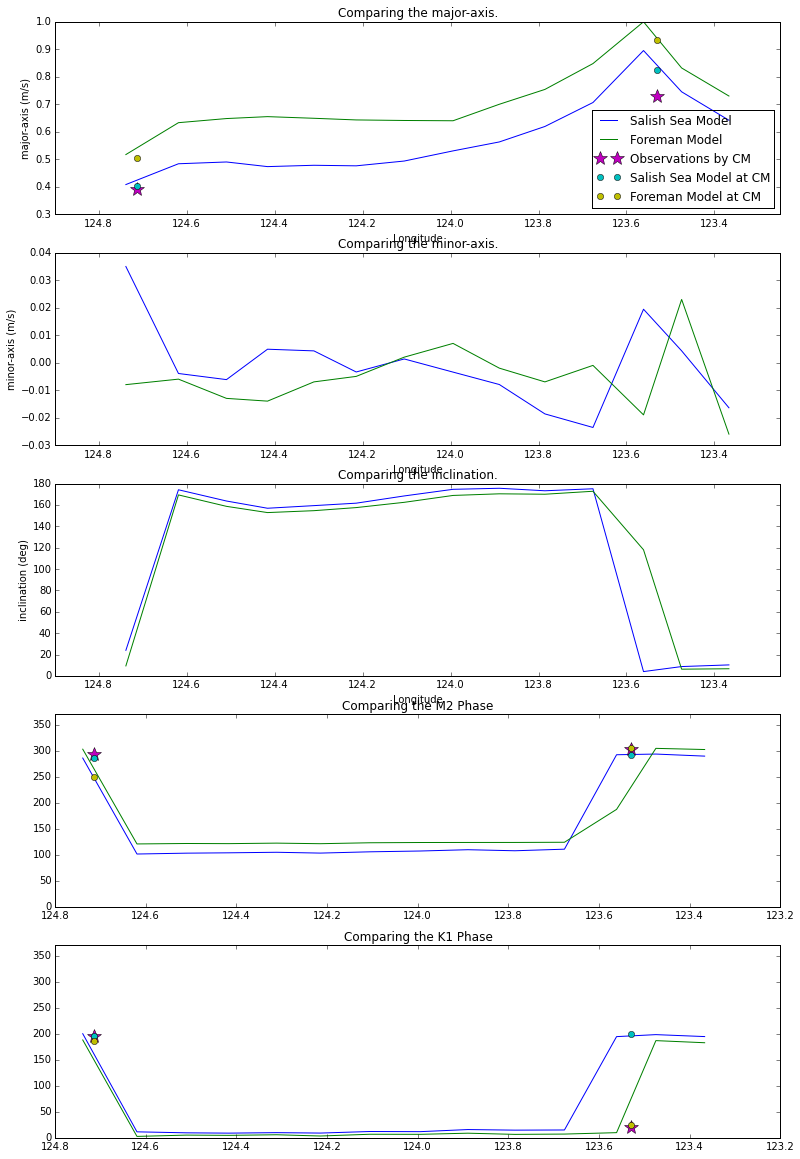

In [83]:
fig, (ax0, ax1, ax2, ax3, ax4)= plt.subplots(5,1,figsize=(13,20))

for ax , k, par, u in zip([ax0, ax1, ax2], [0,1,2], parameter, unit):

    ax.plot(-lon[:],parj_av[:,k], '-', label='Salish Sea Model')
    ax.plot(-lon[:], parjf[:,k], '-', label='Foreman Model')
    ax.set_title('Comparing the {}.'.format(par))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('{} ({})'.format(par,u))
    ax.set_xlim([124.9, 123.25])
ax0.plot(JWlon, JWobs, 'm*', markersize = 14)
ax0.plot(JElon, JEobs, 'm*', markersize = 14, label='Observations by CM') 
ax0.plot(JWlon, params[0,0], 'co')
ax0.plot(JElon, params[1,0], 'co', label = 'Salish Sea Model at CM')
ax0.plot(JWlon, param_mat[0,0], 'yo')
ax0.plot(JElon, param_mat[1,0], 'yo', label = 'Foreman Model at CM')
ax0.legend(loc=0)
for ax, ind ,k in zip([ax3,ax4], [0,1],[3,7]):
    ax.plot(-lon[:], parj_av[:,k], '-', label='Salish Sea Model')
    ax.plot(-lon[:],parjf[:,k],'-', label='Foreman Model')
    ax.plot(JWlon, JWpha[ind], 'm*', markersize = 14)
    ax.plot(JElon, JEpha[ind], 'm*', markersize = 14, label='Observations by CM') 
    ax.plot(JWlon, params[0,k], 'co', label = 'Salish Sea Model at CM')
    ax.plot(JWlon, param_mat[0,k], 'yo', label = 'Foreman Model at CM')
    
    ax.plot(JElon, params[1,k], 'co')
    ax.plot(JElon, param_mat[1,k], 'yo')
    ax.invert_xaxis()
    ax.set_ylim([0,370])
ax3.set_title('Comparing the M2 Phase')
ax4.set_title('Comparing the K1 Phase')